### Load Libraries & Packages

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import pickle
import matplotlib.pyplot as plt
import time

### Import Data and State-Space Model

In [2]:
with open('Data.pickle', 'rb') as f:
    Data = pickle.load(f)
Ti = Data['Ti'] # indoor air temperature in degC
To = Data['To'] # outdoor air temperature in degC
# q_HVAC = Data['q_HVAC'] # HVAC heating rate in W
q_solar = Data['q_solar'] # absorbed solar radiation in W

with open('ss_model.pickle', 'rb') as f:
    ss_model = pickle.load(f)
Ad = ss_model['Ad']
Bd = ss_model['Bd']
Cd = ss_model['Cd']
Dd = ss_model['Dd']

Bd_HVAC = Bd[:,:1]
Bd_dist = Bd[:,1:]
Dd_HVAC = Dd[:1]
Dd_dist = Dd[1:]

### Define functions

In [3]:
def compute_x(x0, u0_HVAC, u0_dist, 
              Ad, Bd_HVAC, Bd_dist):
    return np.dot(Ad,x0) + np.dot(Bd_HVAC,u0_HVAC) + np.dot(Bd_dist,u0_dist)

def compute_y(x0, u0_HVAC, u0_dist, 
              Cd, Dd_HVAC, Dd_dist):
    return np.dot(Cd,x0) + np.dot(Dd_HVAC,u0_HVAC) + np.dot(Dd_dist,u0_dist)

def MPC_simulation(x0,
                   Ad, Bd_HVAC, Bd_dist,
                   Cd, Dd_HVAC, Dd_dist,
                   u_dist,
                   setpoint,
                   pred_horizon):
    N = u_dist.shape[0]
    x = np.zeros((N+1,2))
    y = np.zeros((N,1))
    u_HVAC = np.zeros((N,1))
    x[0,0] = x0[0] # initial Ti
    x[0,1] = x0[1] # initial Tw
    
    # simulation
    for i in range(N):
        t = time.time()
        u_HVAC[i,:] = optimization(x0=x[i,:],
                                   u_dist=u_dist[i:i+pred_horizon,:],
                                   setpoint=setpoint[i:i+pred_horizon,:])
        t_elapsed = time.time() - t
        print('Elapsed time', t_elapsed)
        x[i+1,:] = compute_x(x[i:i+1,:].T,
                             u_HVAC[i:i+1,:].T,
                             u_dist[i:i+1,:].T,
                             Ad, Bd_HVAC, Bd_dist).flatten()
        y[i,:] = compute_y(x[i:i+1,:].T,
                           u_HVAC[i:i+1,:].T,
                           u_dist[i:i+1,:].T,
                           Cd, Dd_HVAC, Dd_dist).flatten()
    return x, y, u_HVAC

def optimization(x0, u_dist, setpoint):
    N = u_dist.shape[0] # number of timesteps
    
    init = np.ones(N) # initial value for the optimization below
    ans = minimize(objective, # using a 
                   init,
                   bounds=([[0,2]]*N),
                   args=(x0, N, u_dist, setpoint)
                   )
    return ans.x[0]*1000

def objective(u_HVAC, x0, N, u_dist, setpoint):
    u_HVAC = u_HVAC[:,None]*1000
    x = np.zeros((N+1,2))
    y = np.zeros((N,1))
    x[0,0] = x0[0] # initial Ti
    x[0,1] = x0[1] # initial Tw
    
    for i in range(N):
        x[i+1,:] = compute_x(x[i:i+1,:].T,
                             u_HVAC[i:i+1,:].T,
                             u_dist[i:i+1,:].T,
                             Ad, Bd_HVAC, Bd_dist).flatten()
        y[i,:] = compute_y(x[i:i+1,:].T,
                           u_HVAC[i:i+1,:].T,
                           u_dist[i:i+1,:].T,
                           Cd, Dd_HVAC, Dd_dist).flatten()
    cost = np.sum((y-setpoint)**2)
    return cost

### Optimization

In [4]:
x0 = [20,15]
u_dist = np.hstack((q_solar[:,None], To[:,None]))
setpoint = np.ones((q_solar.shape[0],1))*22
pred_horizon = 6 * 2

x, y, u_HVAC = MPC_simulation(x0,
                              Ad, Bd_HVAC, Bd_dist,
                              Cd, Dd_HVAC, Dd_dist,
                              u_dist,
                              setpoint,
                              pred_horizon)

Elapsed time 0.08844780921936035
Elapsed time 0.09569430351257324
Elapsed time 0.03799033164978027
Elapsed time 0.06971955299377441
Elapsed time 0.07566952705383301
Elapsed time 0.1479349136352539
Elapsed time 0.1163337230682373
Elapsed time 0.11372065544128418
Elapsed time 0.2732064723968506
Elapsed time 0.4609639644622803
Elapsed time 0.3575422763824463
Elapsed time 0.4867582321166992
Elapsed time 0.4134359359741211
Elapsed time 0.30991077423095703
Elapsed time 0.44127488136291504
Elapsed time 0.36643457412719727
Elapsed time 0.39154648780822754
Elapsed time 0.5209534168243408
Elapsed time 0.4137699604034424
Elapsed time 0.40552353858947754
Elapsed time 0.4633805751800537
Elapsed time 0.4066731929779053
Elapsed time 0.3726997375488281
Elapsed time 0.3611891269683838
Elapsed time 0.34261465072631836
Elapsed time 0.3974134922027588
Elapsed time 0.3508951663970947
Elapsed time 0.3882787227630615
Elapsed time 0.44323301315307617
Elapsed time 0.4417724609375
Elapsed time 0.371514558792114

Elapsed time 0.39628100395202637
Elapsed time 0.5088376998901367
Elapsed time 0.4138829708099365
Elapsed time 0.3406543731689453
Elapsed time 0.4271736145019531
Elapsed time 0.33544421195983887
Elapsed time 0.31496334075927734
Elapsed time 0.39353466033935547
Elapsed time 0.3111073970794678
Elapsed time 0.40421390533447266
Elapsed time 0.3691892623901367
Elapsed time 0.4323256015777588
Elapsed time 0.4341561794281006
Elapsed time 0.390331506729126
Elapsed time 0.44373631477355957
Elapsed time 0.41782140731811523
Elapsed time 0.4437544345855713
Elapsed time 0.4353151321411133
Elapsed time 0.475632905960083
Elapsed time 0.38493871688842773
Elapsed time 0.4339463710784912
Elapsed time 0.5292060375213623
Elapsed time 0.3409569263458252
Elapsed time 0.33908653259277344
Elapsed time 0.34944772720336914
Elapsed time 0.35375428199768066
Elapsed time 0.38410186767578125
Elapsed time 0.3553507328033447
Elapsed time 0.40514445304870605
Elapsed time 0.3329477310180664
Elapsed time 0.34819555282592

Elapsed time 0.4057323932647705
Elapsed time 0.3631327152252197
Elapsed time 0.39818644523620605
Elapsed time 0.37493276596069336
Elapsed time 0.293729305267334
Elapsed time 0.30912184715270996
Elapsed time 0.3695793151855469
Elapsed time 0.3496880531311035
Elapsed time 0.3548755645751953
Elapsed time 0.38869428634643555
Elapsed time 0.3666510581970215
Elapsed time 0.4050133228302002
Elapsed time 0.32155799865722656
Elapsed time 0.3252263069152832
Elapsed time 0.31408119201660156
Elapsed time 0.3979973793029785
Elapsed time 0.35575008392333984
Elapsed time 0.46955442428588867
Elapsed time 0.3104102611541748
Elapsed time 0.2662465572357178
Elapsed time 0.3404669761657715
Elapsed time 0.2738628387451172
Elapsed time 0.29187750816345215
Elapsed time 0.36528491973876953
Elapsed time 0.3231933116912842
Elapsed time 0.3202390670776367
Elapsed time 0.24567461013793945
Elapsed time 0.38190364837646484
Elapsed time 0.3216860294342041
Elapsed time 0.295274019241333
Elapsed time 0.327865600585937

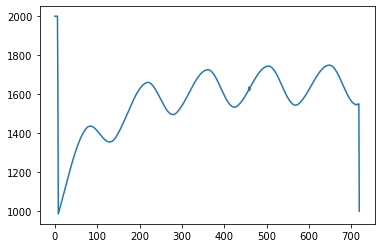

In [5]:
plt.plot(u_HVAC);

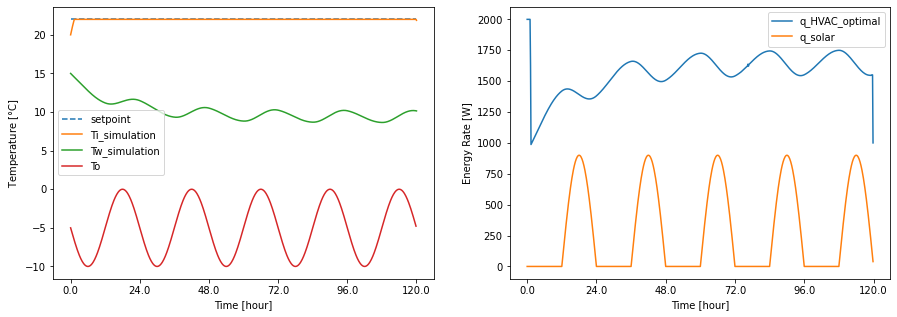

In [6]:
N = x.shape[0]
Ti_simulation = x[:,0] # Indoor temperature 
Tw_simulation = x[:,1]

# plotting
t_span = np.arange(0,N+1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(setpoint, label='setpoint', linestyle='--')
ax[0].plot(Ti_simulation, label='Ti_simulation')
ax[0].plot(Tw_simulation, label='Tw_simulation')
ax[0].plot(To, label='To')
ax[0].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[0].set_ylabel('Temperature [$\degree$C]')
ax[0].set_xlabel('Time [hour]')
ax[0].legend()

ax[1].plot(u_HVAC, label='q_HVAC_optimal')
ax[1].plot(q_solar, label='q_solar')
ax[1].set_xticks(t_span[::6*24],t_span[::6*24]*10/60)
ax[1].set_ylabel('Energy Rate [W]')
ax[1].set_xlabel('Time [hour]')
ax[1].legend()

plt.show()